# UNET Model for Classification

In [1]:
from importsfunctions import *

## Import train and validation dataset

In [ ]:
DATAPATH = 'ISIC2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data_Resize_5721/1/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth_Resize_5721/1/'
DATAPATH_csv='ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv'
x_train,_,y_trainclass,nomeficht=import_datasetBS(DATAPATH,DATAPATH_segm, DATAPATH_csv,2000)

DATAPATH = 'ISIC2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_Resize_5721/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part1_GroundTruth_Resize_5721/'
DATAPATH_csv='ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
x_validation,_,y_validationclass,nomefichv=import_datasetBS(DATAPATH,DATAPATH_segm, DATAPATH_csv,150)


## Import train and validation dataset for data augmentation

In [ ]:
DATAPATH = 'ISIC2017/ISIC-2017_Training_Data/ISIC-2017_Training_Data_Resize_572_Augment/1/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Training_Part1_GroundTruth/ISIC-2017_Training_Part1_GroundTruth_Resize_572_Augment/1/'
DATAPATH_csv='ISIC2017/ISIC-2017_Training_Part3_GroundTruth.csv'
x_train,_,y_trainclass,nomeficht=import_datasetBSrot(DATAPATH,DATAPATH_segm, DATAPATH_csv,4000)

In [2]:
DATAPATH = 'ISIC2017/ISIC-2017_Validation_Data/ISIC-2017_Validation_Data_Resize_5721/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Validation_Part1_GroundTruth/ISIC-2017_Validation_Part1_GroundTruth_Resize_5721/'
DATAPATH_csv='ISIC2017/ISIC-2017_Validation_Part3_GroundTruth.csv'
x_validation,_,y_validationclass,nomefichv=import_datasetBSrot(DATAPATH,DATAPATH_segm, DATAPATH_csv,150)
x_validation=x_validation/255

yes


### Train and Validation Examples

In [ ]:
ix = random.randint(0, 1999)
print(nomeficht[ix])
imshow(x_train[ix])
plt.show()
print(y_trainclass[ix])

In [ ]:
ix = random.randint(0, 149)
print(nomefichv[ix])
imshow(x_validation[ix])
plt.show()
print(y_validationclass[ix])

## Build Model

In [ ]:
batchsize=8
fullysize=1024
poolvalue=3
model = redeUNETclass(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, act='relu',complexity=32,fully=fullysize,pool=poolvalue,dropout_c=True)
model.compile(optimizer=Adam(learning_rate=1e-4, ),loss='categorical_crossentropy',metrics=['categorical_accuracy'],weighted_metrics=['accuracy'])
model.summary()

### Configuration 

In [ ]:
rounded_train=np.argmax(y_trainclass, axis=1)
y_validationclass2=np.argmax(y_validationclass, axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(rounded_train),rounded_train)
class_weightsV = class_weight.compute_class_weight('balanced',np.unique(y_validationclass2),y_validationclass2)
classe_weight= {0 : 1.78253119, 1 : 2.62467192, 2 : 0.48590865 }
classe_weightV= {0 : 1.66666667, 1 : 1.19047619, 2 : 0.64102564 }
train_sample_weight = np.array([classe_weight[cls] for cls in rounded_train])
val_sample_weight = np.array([classe_weightV[cls] for cls in y_validationclass2])

### CallBacks

In [ ]:
Reduce=ReduceLROnPlateau(factor=0.7, patience=5, min_lr=1e-9, verbose=1)
filepath='Class_1.h5'
filepath1='Class_2.h5'
checkpointer = ModelCheckpoint(filepath,monitor='val_accuracy',save_weights_only=True, verbose=1, save_best_only=True)
checkpointer2 = ModelCheckpoint(filepath1,monitor='val_categorical_accuracy',save_weights_only=True, verbose=1, save_best_only=True)
earlystopper = EarlyStopping(patience=40,monitor='val_accuracy', verbose=1)
log_dire = os.path.join(
    "logs",
    "class","final",
    datetime.datetime.now().strftime("%Y%m%d-%H%M%S"),
)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dire, histogram_freq=1)

### Actual training

In [ ]:
data_gen_args = dict(rescale=1./255, horizontal_flip=True,vertical_flip=True )
datagen = ImageDataGenerator(**data_gen_args)
it = datagen.flow(x_train, y_trainclass, sample_weight=train_sample_weight, batch_size=batchsize,shuffle=True)
results=model.fit_generator(it, steps_per_epoch=2000/batchsize,
                    validation_data=(x_validation.astype(np.float32), y_validationclass.astype(np.float32),val_sample_weight),
                    epochs=100, callbacks=[checkpointer,checkpointer2,Reduce,tensorboard_callback,earlystopper],verbose=1)
plot_performanceClassification(results)
del model

## Model predictions:

In [3]:
batchsize=8
fullysize=1024
poolvalue=3
model = redeUNETclass(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, act='relu',complexity=32,fully=fullysize,pool=poolvalue,dropout_c=True)
#model.load_weights("Class_a.h5")
model.load_weights("Weights\Classification\Class_17.h5")

## Train Predictions and Performance:

In [ ]:
#predictions_train = model.predict(x_train,batch_size=4)
#classification_metrics(predictions_train,y_trainclass)

## Validation Predictions and Performance:

In [4]:
predictions_val = model.predict(x_validation,batch_size=4)
classification_metrics(predictions_val,y_validationclass)

Prediction confusion Matrix
[[21  5  4]
 [ 3 36  3]
 [11 12 55]]
Original confusion Matrix
[[30  0  0]
 [ 0 42  0]
 [ 0  0 78]]
Sensivity[M N SK]: 0.700 . 0.705 . 0.857
Specificit[M N SK]: 0.883 . 0.903 . 0.843
Balanced_Accuracy by scikit: 0.754
Categorical Accuracy: 0.747


1
Image: ISIC_0001852.png
Prediction:
[2.6999796e-02 4.3030325e-04 9.7256988e-01]
2
Groundtruth:
2


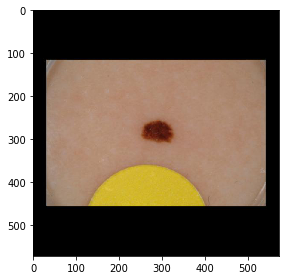

In [151]:
# Melanoma correcto: 30, 107,140,137,133,132,131,103
#Melanoma incorrecto: 106, 127,128,90,76,75,51,25
# SK correcto:48, 115,93,117
# SK incorrecto: 96
# N correcto: 18,126
# N incorrecto: 145,143,142,139,135

#ix = random.randint(0, 150)
#ix=130
ix=ix-1
imshow(x_validation[ix])
print(ix)
print("Image:", nomefichv[ix])
print("Prediction:")
print(predictions_val[ix])
print(np.argmax(predictions_val[ix], axis=0))
print("Groundtruth:")
print(np.argmax(y_validationclass[ix], axis=0))

#print(y_validationclass[ix])

## Test Dataset

In [ ]:
DATAPATH = 'ISIC2017/ISIC-2017_Test_v2_Data/ISIC-2017_Test_v2_Data_Resize_5721/'
DATAPATH_segm = 'ISIC2017/ISIC-2017_Test_v2_Part1_GroundTruth/ISIC-2017_Test_v2_Part1_GroundTruth_Resize_5721/'
DATAPATH_csv='ISIC2017/ISIC-2017_Test_v2_Part3_GroundTruth.csv'
x_validation,y_validation,y_validationclass,nomefichv=import_datasetBSrot(DATAPATH,DATAPATH_segm, DATAPATH_csv,600)
x_validation=x_validation/255

In [ ]:
batchsize=8
fullysize=1024
poolvalue=3
model = redeUNETclass(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, act='relu',complexity=32,fully=fullysize,pool=poolvalue,dropout_c=True)
model.load_weights("Weights/Classification/Class_17.h5")

In [ ]:
predictions_val = model.predict(x_validation,batch_size=4)
classification_metrics(predictions_val,y_validationclass)